# Car Accident Severity Prediction



## Introduction:
Based on Global Status Report on Road Safety 2018 presented by World Health Organization (WHO), 1.35 million people are killed on roadways around the world each year and almost 3,700 people are killed globally in road traffic crashes every day. 

To reduce the number of accidents and Car collisions, consequently the number of deaths, we should identify factors helping to accurately predict car accident Severity such as the current weather and the road conditions. Therefore, using this model, the conductor will be alerted to drive more carefully or change his travel to reduce the possibility of getting in an accident.


## Data Understanding:
### Load Data from CSV file
The dataset used for this project is specified in a CSV file "Data-Collisions.csv" and it can be found here https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv. It includes all types of collisions recorded by Trafic Records from 2004 to 2020.
It is represented as follows: 


In [1]:
#imports
import types
import pandas as pd
import numpy as np 
from botocore.client import Config
import ibm_boto3
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
print("Hello Capstone Project: Car accident Severity!")
df_data_collision = pd.read_csv(body)
df_data_collision.head()

Hello Capstone Project: Car accident Severity!


/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


### Data pre-processing and selection

 Before starting to run any Machine Learning algorithm on the data to predict target value, the data have to go through the preprocessing part. In this part, data will be cleaned so there is no missing or unusual value. The goal is that the data is the best possible before applying the algorithms.
 Lets first look at columns data types:


In [4]:
df_data_collision.dtypes


SEVERITYCODE        int64
X                 float64
Y                 float64
OBJECTID            int64
INCKEY              int64
COLDETKEY           int64
REPORTNO           object
STATUS             object
ADDRTYPE           object
INTKEY            float64
LOCATION           object
EXCEPTRSNCODE      object
EXCEPTRSNDESC      object
SEVERITYCODE.1      int64
SEVERITYDESC       object
COLLISIONTYPE      object
PERSONCOUNT         int64
PEDCOUNT            int64
PEDCYLCOUNT         int64
VEHCOUNT            int64
INCDATE            object
INCDTTM            object
JUNCTIONTYPE       object
SDOT_COLCODE        int64
SDOT_COLDESC       object
INATTENTIONIND     object
UNDERINFL          object
WEATHER            object
ROADCOND           object
LIGHTCOND          object
PEDROWNOTGRNT      object
SDOTCOLNUM        float64
SPEEDING           object
ST_COLCODE         object
ST_COLDESC         object
SEGLANEKEY          int64
CROSSWALKKEY        int64
HITPARKEDCAR       object
dtype: objec

The target variable will be **"SEVERITYCODE"**. This attribute corresponds to the severity of a collision which assigns:
 * *Category 1* : Property Damage No injury 
 * *Category 2* : injury
 
 Dependant varaibles will be:
 1. **"WEATHER"** : A description of the weather conditions during the time of the collision. 
 2. **"ROADCOND"**: The condition of the road during the collision
 3. **"LIGHTCOND"**: Light conditions at the time of the collision

 
 It looks like WEATHER,ROADCOND,and LIGHTCOND columns contains categorical data. So, we minimised the dataset to 4 columns ("SEVERITYCODE","WEATHER","ROADCOND","LIGHTCOND") and delete missing values.
    

In [5]:
df_collision= df_data_collision[['SEVERITYCODE','WEATHER','ROADCOND','LIGHTCOND']]
df_collision =df_collision.dropna()

In [6]:
df_collision.head()

,SEVERITYCODE,WEATHER,ROADCOND,LIGHTCOND
0,2,Overcast,Wet,Daylight
1,1,Raining,Wet,Dark - Street Lights On
2,1,Overcast,Dry,Daylight
3,1,Clear,Dry,Daylight
4,2,Raining,Wet,Daylight


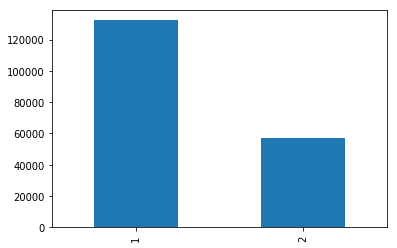

In [7]:
#Choose columns for the filtered dataframe
df_collision['SEVERITYCODE'].value_counts().plot(kind='bar')

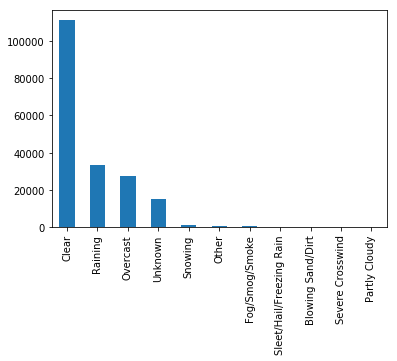

In [8]:
df_collision['WEATHER'].value_counts().plot(kind='bar')

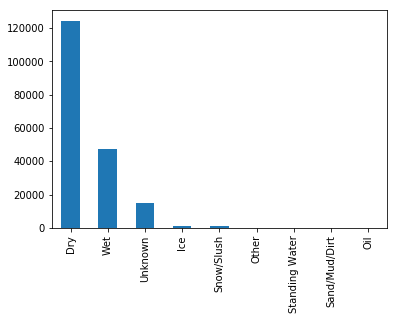

In [9]:
df_collision['ROADCOND'].value_counts().plot(kind='bar')

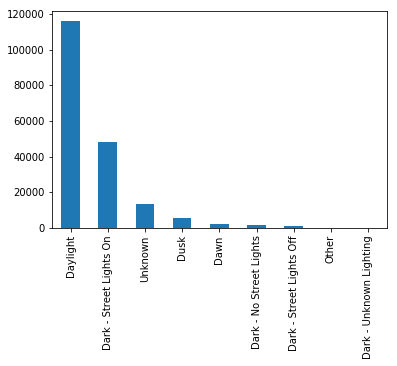

In [10]:
df_collision['LIGHTCOND'].value_counts().plot(kind='bar')

In [11]:
#Encoding Road Conditions(0 = Not slippery, 1 = Medium Slippery, 2 = Very Slippery , 3: Unknown)

print(df_collision["ROADCOND"].value_counts())
encoding_roadcond = {"ROADCOND": {"Dry": 0, "Wet": 1, "Ice": 2, "Snow/Slush": 1, "Standing Water": 1, "Sand/Mud/Dirt": 1,"Oil":2, "Unknown":3 ,"Other":3}}
df_collision.replace(encoding_roadcond, inplace=True)
print(df_collision["ROADCOND"].value_counts())


Dry               124300
Wet                47417
Unknown            15031
Ice                 1206
Snow/Slush           999
Other                131
Standing Water       115
Sand/Mud/Dirt         74
Oil                   64
Name: ROADCOND, dtype: int64
0    124300
1     48605
3     15162
2      1270
Name: ROADCOND, dtype: int64


In [12]:
#Encoding Light Conditions(0 = bright, 1 = Medium light, 2 = Dark, 3 = Unknown)
print(df_collision["LIGHTCOND"].value_counts())
encoding_light = {"LIGHTCOND": {"Daylight": 0, "Dark - Street Lights On": 1, "Dusk": 1, "Dawn": 1, "Dark - No Street Lights": 2, "Dark - Street Lights Off": 2,"Dark - Unknown Lighting":2, "Unknown":3 ,"Other":3}}
df_collision.replace(encoding_light, inplace=True)
print(df_collision["LIGHTCOND"].value_counts())


Daylight                    116077
Dark - Street Lights On      48440
Unknown                      13456
Dusk                          5889
Dawn                          2502
Dark - No Street Lights       1535
Dark - Street Lights Off      1192
Other                          235
Dark - Unknown Lighting         11
Name: LIGHTCOND, dtype: int64
0    116077
1     56831
3     13691
2      2738
Name: LIGHTCOND, dtype: int64


In [13]:
#Encoding WEATHER Conditions(0 = Clear, 1 = overcast/cloudy, 2 = Windy, 3 = Rain/Snow, 4 = Unknown )

print(df_collision["WEATHER"].value_counts())
encoding_weather = {"WEATHER": {"Clear": 0, "Raining": 3, "Overcast": 1, "Snowing": 3, "Fog/Smog/Smoke": 2, "Sleet/Hail/Freezing Rain": 3,"Blowing Sand/Dirt":2 , "Severe Crosswind":2, "Partly Cloudy":1, "Unknown":4 ,"Other":4}}
df_collision.replace(encoding_weather, inplace=True)
print(df_collision["WEATHER"].value_counts())


Clear                       111008
Raining                      33117
Overcast                     27681
Unknown                      15039
Snowing                        901
Other                          824
Fog/Smog/Smoke                 569
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               55
Severe Crosswind                25
Partly Cloudy                    5
Name: WEATHER, dtype: int64
0    111008
3     34131
1     27686
4     15863
2       649
Name: WEATHER, dtype: int64


#### Balancing Dataset

Ou dataset is imbalanced. In fact, SEVERITYCODE in class 1 is nearly two times the size of class 2.

We can fix this by downsampling the majority class.

In [14]:
df_collision['SEVERITYCODE'].value_counts()

1    132285
2     57052
Name: SEVERITYCODE, dtype: int64

In [15]:
# Separate majority and minority classes
df_collision_majority = df_collision[df_collision.SEVERITYCODE==1]
df_collision_minority = df_collision[df_collision.SEVERITYCODE==2]
 
# Downsample majority class
df_majority_downsampled = resample(df_collision_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=57052,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_collision = pd.concat([df_majority_downsampled, df_collision_minority])
 
# Display new class counts
df_collision.SEVERITYCODE.value_counts()

2    57052
1    57052
Name: SEVERITYCODE, dtype: int64

Our dataset in Now perfectly balanced

In [16]:
df_collision.head(10)

,SEVERITYCODE,WEATHER,ROADCOND,LIGHTCOND
82770,1,0,0,0
122946,1,0,0,0
102968,1,0,0,0
13906,1,1,0,0
123301,1,3,1,1
76690,1,0,0,1
192607,1,0,0,0
105520,1,1,1,1
22145,1,0,0,0
145227,1,0,0,0


## Data Modeling ##


### Feature Selection ###

Lets define Feature set X and labels y:

In [17]:
X = df_collision[['WEATHER','ROADCOND','LIGHTCOND']].values
X[0:5]

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [1, 0, 0],
       [3, 1, 1]])

In [18]:
y = df_collision['SEVERITYCODE'].values
y[0:5]

array([1, 1, 1, 1, 1])

### Normalize Data ###

In [19]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[-0.69929493, -0.57980166, -0.63267068],
       [-0.69929493, -0.57980166, -0.63267068],
       [-0.69929493, -0.57980166, -0.63267068],
       [ 0.02209617, -0.57980166, -0.63267068],
       [ 1.46487838,  0.68504278,  0.65455616]])

### Train/Test Split ###
we split our dataset into train and test set: We will use 20% of our data for testing and 80% for training

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (91283, 3) (91283,)
Test set: (22821, 3) (22821,)


### **K Nearest Neighbours** ###

We  calculate the accuracy of KNN for different K and Plot  model accuracy  for Different number of Neighbors

In [ ]:
K = 20
mean_acc = np.zeros((K-1))
std_acc = np.zeros((K-1))
ConfustionMx = [];
for n in range(1,K):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

In [ ]:
plt.plot(range(1,K),mean_acc,'g')
plt.fill_between(range(1,K),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [ ]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

### **Decision Tree** ###

In [22]:
CollisionTree = DecisionTreeClassifier(criterion="entropy",max_depth=7)
CollisionTree
CollisionTree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [23]:
predTree = CollisionTree.predict(X_test)
print(predTree[0:5])
print(y_test[0:5])

[2 2 1 2 2]
[1 2 2 1 1]


### **Logistic Regression** ###

Because our dataset only provides us with two severity code outcomes, our model will only predict one of those two classes. This makes our data binary, which is perfect to use with logistic regression.

In [24]:
LR = LogisticRegression(C=6,solver='liblinear').fit(X_train,y_train)
LR
LRyhat = LR.predict(X_test)
LRyhat

array([2, 2, 1, ..., 1, 2, 2])

In [25]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.4385178 , 0.5614822 ],
       [0.4385178 , 0.5614822 ],
       [0.52509442, 0.47490558],
       ...,
       [0.52509442, 0.47490558],
       [0.4385178 , 0.5614822 ],
       [0.36479815, 0.63520185]])

## Model Evaluation ##

In [26]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

neigh = KNeighborsClassifier(n_neighbors = 4).fit(X_train,y_train)
KNNyhat = neigh.predict(X_test)
Jaccard_score_KNN = jaccard_similarity_score(y_test,KNNyhat)
F1_score = f1_score(y_test, KNNyhat, average='macro',labels=np.unique(KNNyhat)) 
print("KNN Avg F1-score: %.4f" % F1_score)
print("KNN Jaccard score: %.4f" % Jaccard_score_KNN)

KNN Avg F1-score: 0.4657
KNN Jaccard score: 0.5110


In [27]:
Jaccard_score_DT = jaccard_similarity_score(y_test,predTree)
F1_score_DT = f1_score(y_test, predTree, average='macro',labels=np.unique(predTree)) 
print("DT Avg F1-score: %.4f" % F1_score_DT)
print("DT Jaccard score: %.4f" % Jaccard_score_DT)

DT Avg F1-score: 0.5372
DT Jaccard score: 0.5573


In [28]:
Jaccard_score_LR = jaccard_similarity_score(y_test,LRyhat)
F1_score_LR = f1_score(y_test, LRyhat, average='macro') 
print("LR Avg F1-score: %.4f" % F1_score_LR)
print("LR Jaccard score: %.4f" % Jaccard_score_LR)

LR Avg F1-score: 0.5446
LR Jaccard score: 0.5493


## Results ##

Evaluation Results of the differents models used to predict the Car Accident Severity

|Models             | Jaccard           | F1-Score   |
| ------------------|:-----------------:| ----------:|
| KNN               | 0.5110            | 0.4657     |
| DT                | 0.5573            | 0.5372     |
| Linear Regression | 0.5793            | 0.5446     |

Considering the table, the best model to use is the Linear Regression Model (Jaccard and F score closest to 1).

## Discussion ##

For our study, we choosed 3 independant variables to predict the severity Code of an accident. 
By modifying and increasinf the number of independant variables we can get better predictions. Also, by tuning model's parametres ( K nmber for KNN , type of criterion and max_depth for decision tree.), models may be more accurate.

# Conclusion

Using data provided by Seattle Police Department, we tested different models to predict severity of car collisions based on weather, road and light conditions. 